# Elo Ratingによる予測
[kaggle notebook](https://www.kaggle.com/code/lennarthaupts/calculate-elo-ratings)

以下の統計量を使用
- Rating_Mean: The average team rating in a regular season.
- Rating_Median: The median team rating in a regular season.
- Rating_Last: The last rating in a regular season/ the final rating before the tournament.
- Rating_Std: Standard Deviation of team ratings.
- Rating_Max: The maximum team rating in a season.
- Rating_Min: The minimum team rating in a season.
- Rating_Trend: The slope of the team's rating over the season.

In [11]:
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import linregress
from tqdm import tqdm

sys.path.append(os.path.abspath("/workspace"))
with initialize_config_module(version_base=None, config_module="conf"):
    cfg = compose(
        config_name="base.yaml",
        overrides=[
            "exp=exp002" #defaultexp001->exp002のオーバーライド
        ],
    )
    
    OmegaConf.resolve(cfg)
    print("Omega conf is below")
    print(OmegaConf.to_yaml(cfg))
    
"""
#こんな感じでkeyとval取得できる
print(cfg.dir.keys())
print(cfg.exp)"""

INPUT_PATH = cfg.dir.input_dir
OUTPUT_PATH = cfg.dir.output_dir
SRC_PATH = cfg.dir.src_path
CONF_PATH = cfg.dir.conf_path

sys.path.append(SRC_PATH)

Omega conf is below
dir:
  input_dir: ../input
  output_dir: ../output/2025-02-15_19-20-02
  src_path: ../src
  conf_path: ../conf
model:
  epochs: 10
  lr: 0.001
exp:
  model:
    hidden_size: 100
    learning_rate: 0.1
    batch_size: 640
    num_epochs: 50



In [12]:
def calculate_elo(teams, data, initial_rating=2000, k=140, alpha=None, weights=False, nan_score=1):
    '''
    Calculate Elo ratings for each team based on match data.

    Parameters:
    - teams (array-like): Containing Team-IDs.
    - data (pd.DataFrame): DataFrame with all matches in chronological order.
    - initial_rating (float): Initial rating of an unranked team (default: 2000).
    - k (float): K-factor, determining the impact of each match on team ratings (default: 140).
    - alpha (float or None): Tuning parameter for the multiplier for the margin of victory. No multiplier if None.

    Returns: 
    - list: Historical ratings of the winning team (WTeam).
    - list: Historical ratings of the losing team (LTeam).
    '''
    
    # Dictionary to keep track of current ratings for each team
    team_dict = {}
    for team in teams:
        team_dict[team] = initial_rating
        
    # Lists to store ratings for each team in each game
    r1, r2 = [], []
    loss = []
    margin_of_victory = 1
    weight = 1

    # Iterate through the game data
    for wteam, lteam, ws, ls, w  in tqdm(zip(data.WTeamID, data.LTeamID, data.WScore, data.LScore, data.weight), total=len(data)):

        # Calculate expected outcomes based on Elo ratings
        rateW = 1 / (1 + 10 ** ((team_dict[lteam] - team_dict[wteam]) / initial_rating))
        rateL = 1 / (1 + 10 ** ((team_dict[wteam] - team_dict[lteam]) / initial_rating))
        
        if alpha:
                margin_of_victory = (ws - ls)/alpha
        if isinstance(weights, (list, np.ndarray, pd.Series)):
            weight = w

        # Update ratings for winning and losing teams
        team_dict[wteam] += w * k * margin_of_victory * (1 - rateW)
        team_dict[lteam] += w * k * margin_of_victory * (0 - rateL)

        # Ensure that ratings do not go below 1
        if team_dict[lteam] < 1:
            team_dict[lteam] = 1
            
        # Append current ratings for teams to lists
        r1.append(team_dict[wteam])
        r2.append(team_dict[lteam])
        loss.append((1-rateW)**2)
        
    return r1, r2, loss

def create_elo_data(teams, data, initial_rating=2000, k=140, alpha=None, weights=None, nan_score=1):
    '''
    Create a DataFrame with summary statistics of Elo ratings for teams based on historical match data.

    Parameters:
    - teams (array-like): Containing Team-IDs.
    - data (pd.DataFrame): DataFrame with all matches in chronological order.
    - initial_rating (float): Initial rating of an unranked team (default: 2000).
    - k (float): K-factor, determining the impact of each match on team ratings (default: 140).
    - weights (array-like): Containing weights for each match.

    Returns: 
    - DataFrame: Summary statistics of Elo ratings for teams throughout a season.
    '''
    
    if isinstance(weights, (list, np.ndarray, pd.Series)):
        data['weight'] = weights
    else:
        data['weight'] = 1

    r1, r2, loss = calculate_elo(teams, data, initial_rating, k, alpha, weights, nan_score)
    # Calculate loss only on tourney results
    loss = np.mean(np.array(loss)[data.tourney == 1])
    print(f"Loss: {loss}")
    
    # Concatenate arrays vertically
    seasons = np.concatenate([data.Season, data.Season])
    days = np.concatenate([data.DayNum, data.DayNum])
    teams = np.concatenate([data.WTeamID, data.LTeamID])
    tourney = np.concatenate([data.tourney, data.tourney])
    ratings = np.concatenate([r1, r2])
    # Create a DataFrame
    rating_df = pd.DataFrame({
        'Season': seasons,
        'DayNum': days,
        'TeamID': teams,
        'Rating': ratings,
        'Tourney': tourney
    })

    # Sort DataFrame and remove tournament data
    rating_df.sort_values(['TeamID', 'Season', 'DayNum'], inplace=True)
    rating_df = rating_df[rating_df['Tourney'] == 0]
    grouped = rating_df.groupby(['TeamID', 'Season'])
    results = grouped['Rating'].agg(['mean', 'median', 'std', 'min', 'max', 'last'])
    results.columns = ['Rating_Mean', 'Rating_Median', 'Rating_Std', 'Rating_Min', 'Rating_Max', 'Rating_Last']
    results['Rating_Trend'] = grouped.apply(lambda x: linregress(range(len(x)), x['Rating']).slope, include_groups=False)
    results.reset_index(inplace=True)
    
    return results
        

In [13]:
# Load and Process Data Men's Tourney
regular_m = pd.read_csv(os.path.join(INPUT_PATH, "MRegularSeasonCompactResults.csv"))
tourney_m = pd.read_csv(os.path.join(INPUT_PATH, "MNCAATourneyCompactResults.csv"))
teams_m = pd.read_csv(os.path.join(INPUT_PATH, "MTeams.csv"))

regular_m['tourney'] = 0
tourney_m['tourney'] = 1
regular_m['weight'] = 1
tourney_m['weight'] = 0.7

data_m = pd.concat([regular_m, tourney_m])
data_m.sort_values(['Season', 'DayNum'], inplace=True)
data_m.reset_index(inplace=True, drop=True)

elo_df_men = create_elo_data(teams_m.TeamID, data_m, initial_rating=1200, k=125, alpha=None, weights=data_m['weight'])

100%|██████████| 193289/193289 [00:00<00:00, 567926.12it/s]


Loss: 0.1881333201818146


In [14]:
# Load and Process Data Women's Tourney
regular_w = pd.read_csv(os.path.join(INPUT_PATH, "WRegularSeasonCompactResults.csv"))
tourney_w = pd.read_csv(os.path.join(INPUT_PATH, "WNCAATourneyCompactResults.csv"))
teams_w = pd.read_csv(os.path.join(INPUT_PATH, "WTeams.csv"))

regular_w['tourney'] = 0
tourney_w['tourney'] = 1
regular_w['weight'] = 0.95
tourney_w['weight'] = 1

data_w = pd.concat([regular_w, tourney_w])
data_w.sort_values(['Season', 'DayNum'], inplace=True)
data_w.reset_index(inplace=True, drop=True)

elo_df_women = create_elo_data(teams_w.TeamID, data_w, initial_rating=1250, k=190, alpha=None, weights=data_w['weight'])

100%|██████████| 136611/136611 [00:00<00:00, 590332.02it/s]


Loss: 0.1483454322346713


In [15]:
# Save to csv
elo_df_men.to_csv('mens_elo_rating.csv')
elo_df_women.to_csv('womens_elo_rating.csv')

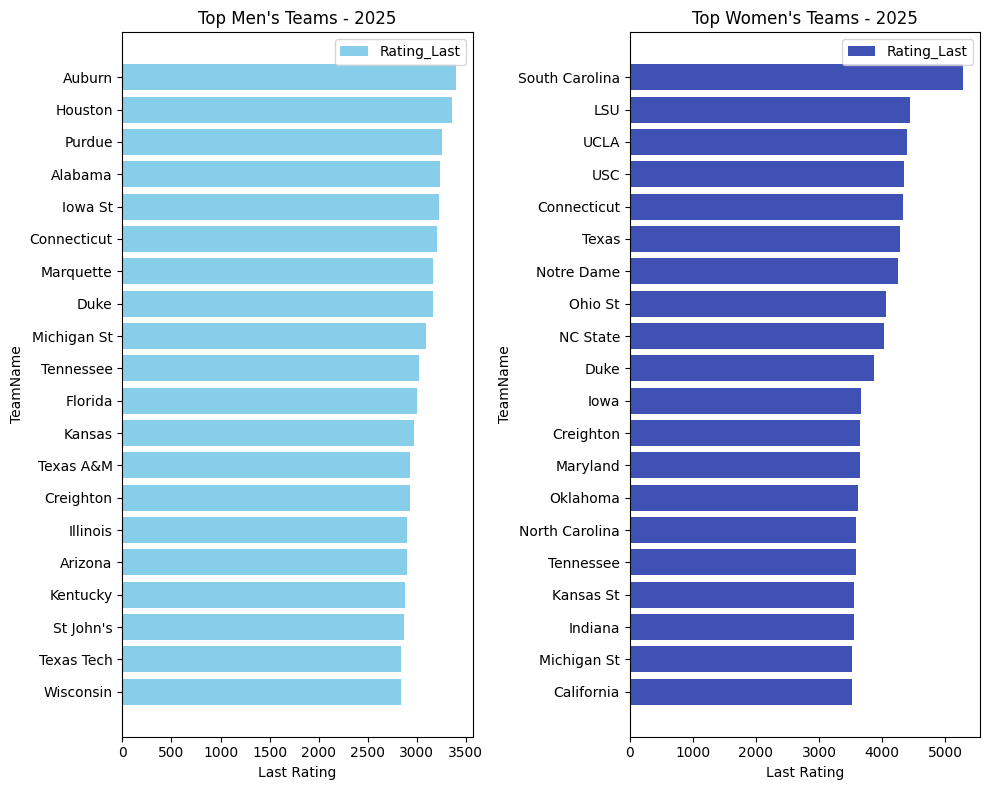

In [16]:
# Men's Teams
tmp_df_men = pd.merge(elo_df_men, teams_m, on='TeamID', how='left')
tmp_df_men = tmp_df_men[tmp_df_men['Season'] == 2025]
top_men_teams = tmp_df_men.sort_values('Rating_Last', ascending=False)[:20][['TeamName', 'Rating_Last', 'Rating_Trend']]
top_men_teams = top_men_teams.reindex(index=top_men_teams.index[::-1])

# Women's Teams
tmp_df_women = pd.merge(elo_df_women, teams_w, on='TeamID', how='left')
tmp_df_women = tmp_df_women[tmp_df_women['Season'] == 2025]
top_women_teams = tmp_df_women.sort_values('Rating_Last', ascending=False)[:20][['TeamName', 'Rating_Last', 'Rating_Trend']]
top_women_teams = top_women_teams.reindex(index=top_women_teams.index[::-1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

# Men's Teams
ax1.barh(top_men_teams['TeamName'], top_men_teams['Rating_Last'], color='skyblue', label='Rating_Last')
ax1.set_title("Top Men's Teams - 2025")
ax1.set_xlabel('Last Rating')
ax1.set_ylabel('TeamName')
ax1.legend()

# Women's Teams
ax2.barh(top_women_teams['TeamName'], top_women_teams['Rating_Last'], color='#3F51B5', label='Rating_Last')
ax2.set_title("Top Women's Teams - 2025")
ax2.set_xlabel('Last Rating')
ax2.set_ylabel('TeamName')
ax2.legend()

plt.tight_layout()
plt.show()